In [120]:
# Step 1: Import asset pricing from Yahoo Finance

In [221]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [141]:
stock_data = yf.download("GS", start="1990-05-04", end="2022-02-21")
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


In [145]:
# Step 2: Create x_train & y_train data so RNN uses percentage change data to make a binary forecast

In [146]:
x_train = []
y_train = []

input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

In [147]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [148]:
mu = y_train.mean()
volume = y_train.std()

In [190]:
RW = np.random.normal(mu,volume,len(x_train))
df_in = pd.DataFrame(RW, columns=['RW'])
df_in['RW'] = df_in['RW'].apply(lambda y: 1 if y>0 else 0)

In [192]:
y= pd.DataFrame(y_train, columns=['y_train'])

In [193]:
y['y_train'] = y['y_train'].apply(lambda y: 1 if y>0 else 0)

In [194]:
y_train = np.array(y)

In [195]:
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
144/144 [==============================] - 4s 6ms/step - loss: 0.6931
Epoch 2/5
144/144 [==============================] - 1s 6ms/step - loss: 0.6935
Epoch 3/5
144/144 [==============================] - 1s 6ms/step - loss: 0.6932
Epoch 4/5
144/144 [==============================] - 1s 6ms/step - loss: 0.6933
Epoch 5/5
144/144 [==============================] - 1s 6ms/step - loss: 0.6932


In [196]:
y_train_pred = model.predict(x_train)

144/144 [==============================] - 1s 3ms/step


In [197]:
df_in['y_train_pred'] = y_train_pred 
df_in['y_train_pred'] = df_in['y_train_pred'].apply(lambda y: 1 if y>0.5 else 0)
df_in['y_train'] = y_train

In [200]:
in_acc = round(accuracy_score(df_in['y_train'], df_in['y_train_pred']),2)

In [201]:
in_acc

0.51

In [203]:
RW_sample_acc = round(accuracy_score(df_in['y_train'], df_in['RW']),2)

In [204]:
RW_sample_acc

0.49

In [205]:
df_in

,RW,y_train_pred,y_train
0,0,1,0
1,0,1,1
2,0,1,0
3,1,1,0
4,1,1,0
...,...,...,...
4581,1,1,1
4582,1,1,1
4583,0,1,0
4584,0,1,1


In [206]:
# Step 3: Test your model and compare insample Accurracy, insample random walk assumption Accuracy, 
# Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [207]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

36/36 [==============================] - 0s 3ms/step


In [208]:
y = pd.DataFrame(y_test, columns=['y_test'])

In [209]:
y['y_test'] = y['y_test'].apply(lambda y: 1 if y>0 else 0)

In [210]:
y['pred'] = predictions

In [211]:
y['pred'] = y['pred'].apply(lambda y: 1 if y>0 else 0)

In [212]:
RW_test = np.random.normal(mu,volume,len(x_test))

In [213]:
y['RW'] = RW_test
y['RW'] = y['RW'].apply(lambda y: 1 if y>0 else 0)
y

,y_test,pred,RW
0,1,1,0
1,0,1,0
2,0,1,1
3,1,1,0
4,1,1,1
...,...,...,...
1143,0,1,0
1144,1,1,0
1145,0,1,1
1146,0,1,0


In [214]:
out_sample = round(accuracy_score(y['y_test'], y['pred']),2)
print("Out of Sample Accuracy:", out_sample)

Out of Sample Accuracy: 0.5


In [216]:
RW_test_acc = round(accuracy_score(y['y_test'], y['RW']),2)
print("Random Walk Accuracy:", RW_test_acc)

Random Walk Accuracy: 0.49


In [217]:
#Step 4: Plot in and out of sample accuracy

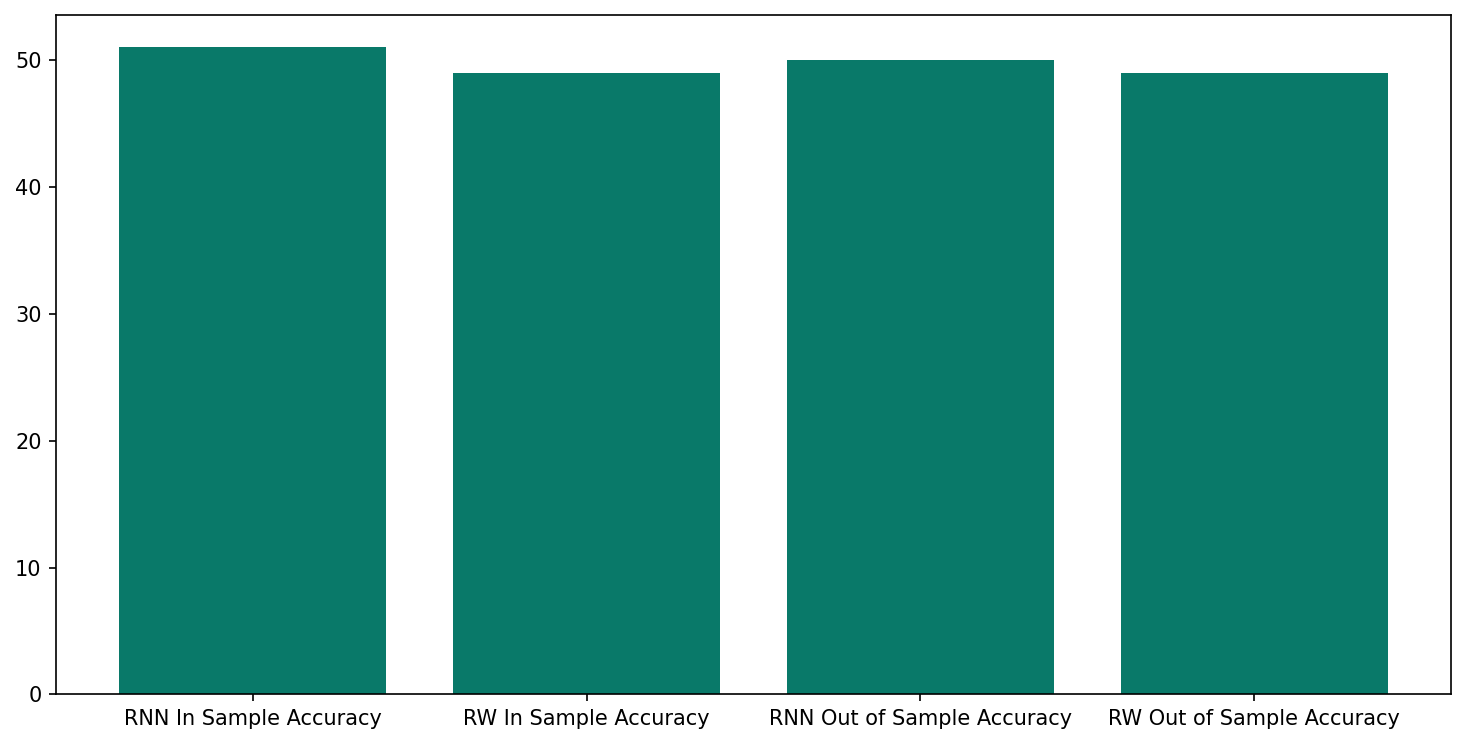

In [230]:
plt.figure(figsize=(12,6), dpi=150)
height = [51, 49, 50, 49]
bars = ('RNN In Sample Accuracy', 'RW In Sample Accuracy', 'RNN Out of Sample Accuracy', 'RW Out of Sample Accuracy')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color = '#097969')
plt.xticks(y_pos, bars)
plt.show()

In [ ]:
# Analysis: There's not much of a different between in and out of sample accuracy